In [1]:
from src.utils.quantization import export_and_quantize_dinov2, load_input, load_model, export_dinov2, load_input_fixed
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt
from demo import VisualizationDemo
from detectron2.data.detection_utils import read_image
from copy import copy
import torch
import torchvision.transforms as T

In [2]:
image_path = "artifacts/idea_raw.jpg"
# image_path = "artifacts/white.jpg"
img, example_kwargs = load_input_fixed(image_path=image_path)

In [3]:
model = load_model()

/Users/dgcnz/development/amsterdam/edge/detrex/detrex/layers/dcn_v3.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/Users/dgcnz/development/amsterdam/edge/detrex/detrex/layers/dcn_v3.py:53: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):


[09/05 11:22:44 timm backbone]: backbone out_indices: (11,)
[09/05 11:22:44 timm backbone]: backbone out_channels: [768]
[09/05 11:22:44 timm backbone]: backbone out_strides: [16]


/Users/dgcnz/development/amsterdam/edge/.venv/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f

In [4]:
exported_model = export_dinov2(model, example_kwargs)

/Users/dgcnz/development/amsterdam/edge/.venv/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
image_path = "artifacts/ams.jpg"
img, example_kwargs = load_input_fixed(image_path=image_path)

In [6]:
with torch.no_grad():
    out = model(**example_kwargs)
    del model

In [7]:
with torch.no_grad():
    out_exported = exported_model.module()(**example_kwargs)
    del exported_model

/Users/dgcnz/development/amsterdam/edge/.venv/lib/python3.10/site-packages/torch/export/_unlift.py:60: UserWarning: Attempted to insert a get_attr Node with no underlying reference in the owning GraphModule! Call GraphModule.add_submodule to add the necessary submodule, GraphModule.add_parameter to add the necessary Parameter, or nn.Module.register_buffer to add the necessary buffer
  getattr_node = gm.graph.get_attr(lifted_node)
/Users/dgcnz/development/amsterdam/edge/.venv/lib/python3.10/site-packages/torch/fx/graph.py:1580: UserWarning: Node pixel_mean target pixel_mean pixel_mean of  does not reference an nn.Module, nn.Parameter, or buffer, which is what 'get_attr' Nodes typically target
  warnings.warn(f'Node {node} target {node.target} {atom} of {seen_qualname} does '
/Users/dgcnz/development/amsterdam/edge/.venv/lib/python3.10/site-packages/torch/fx/graph.py:1580: UserWarning: Node pixel_std target pixel_std pixel_std of  does not reference an nn.Module, nn.Parameter, or buffer,

In [8]:
def filter_predictions_with_confidence(predictions, confidence_threshold=0.5):
    if "instances" in predictions:
        preds = predictions["instances"]
        keep_idxs = preds.scores > confidence_threshold
        predictions = copy(predictions) # don't modify the original
        predictions["instances"] = preds[keep_idxs]
    return predictions

In [9]:
out = filter_predictions_with_confidence(out)

In [10]:
out_exported = filter_predictions_with_confidence(out_exported)

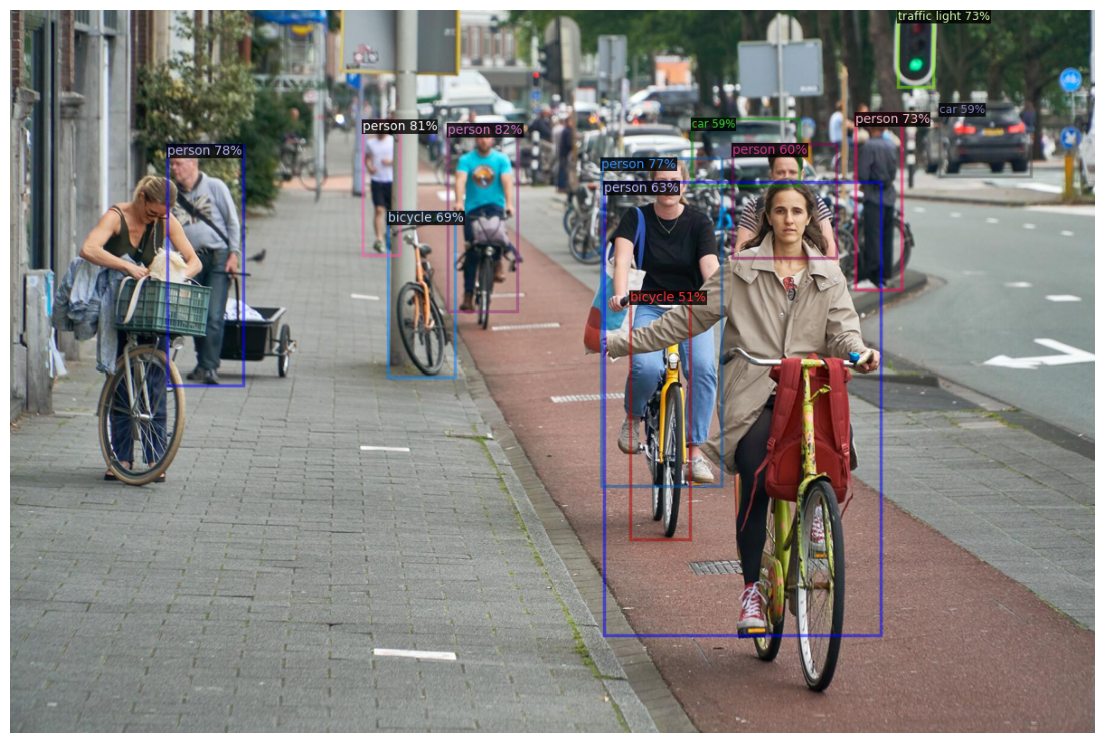

In [11]:

v = Visualizer(img, MetadataCatalog.get("coco_2017_val"))
pred = filter_predictions_with_confidence(out[0], confidence_threshold=0.5)
v = v.draw_instance_predictions(pred["instances"].to("cpu"))

# Display the results
plt.figure(figsize=(14, 10))
plt.imshow(v.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

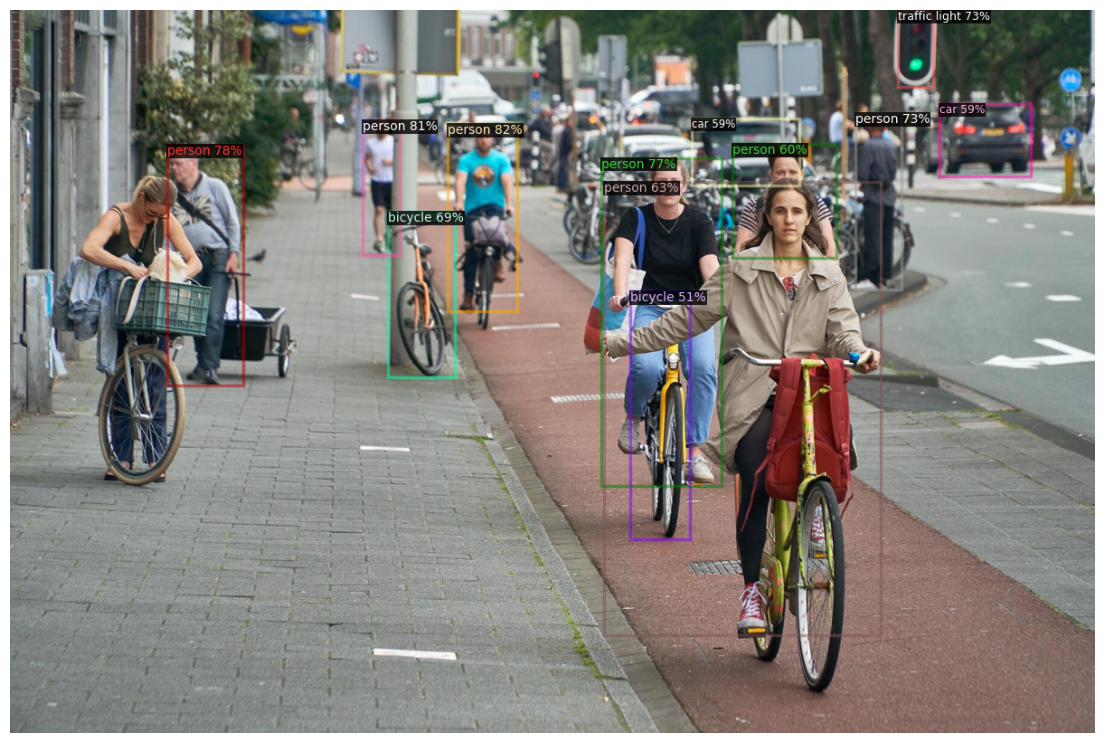

In [12]:

v = Visualizer(img, MetadataCatalog.get("coco_2017_val"))
pred = filter_predictions_with_confidence(out_exported[0], confidence_threshold=0.5)
v = v.draw_instance_predictions(pred["instances"].to("cpu"))

# Display the results
plt.figure(figsize=(14, 10))
plt.imshow(v.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()